# UNet model

Running the UNet from here 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import skorch
import torchvision.datasets as dset
import torchvision.models as models
import collections
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision.transforms as transforms
from tqdm import tqdm

%matplotlib inline

from optparse import OptionParser
from unet import UNet
from utils import *
from myloss import dice_coeff


import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from UNet_Loader import ILDDataset

/Users/CharlesAkin-David/Documents/CS231N/project/cs231n_bmi260_project/.env/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
NUM_TOTAL = 885
NUM_TRAIN = 700

lung_dataset_train = ILDDataset(cystic_path='../../Cyst Dataset/Cystic_masks_new/Train',
                          root_dir='../../Cyst Dataset/Train',
                          mask=True, HU=True, resize=256)

lung_dataset_test = ILDDataset(cystic_path='../../Cyst Dataset/Cystic_masks_new/Test',
                          root_dir='../../Cyst Dataset/Test',
                          mask=True, HU=True, resize=256)

loader_train = DataLoader(lung_dataset_train, batch_size=4, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(lung_dataset_train, batch_size=4, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTAL)))

loader_test = DataLoader(lung_dataset_test, batch_size=4)

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


# Check Accuracy

In [22]:
def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.0

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [7]:
def eval_net(net, loader, device, gpu=False):
    if loader.dataset.train:
        print('Checking accuracy on training set')
    else:
        print('Checking accuracy on test set')   

    tot = 0
    cntr = 0
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            if gpu:
                X = Variable(X, requires_grad=True).cuda()
                y = Variable(y, requires_grad=True).cuda()
            else:
                X = Variable(X, requires_grad=True)
                y = Variable(y, requires_grad=True)

            X.unsqueeze_(1)
            y.unsqueeze_(1)
            y_pred = net(X)

            y_pred = (F.sigmoid(y_pred) > 0.6).float()
            dice = dice_coeff(y_pred, y.float()).data[0]
            tot += dice
            cntr += 1
            
            if 0:
                X = X.data.squeeze(1).cpu().numpy()
                print('X', X.shape)
                X = np.transpose(X, axes=[1, 2, 0])
                print('X.T', X.shape)
                y = y.data.squeeze(1).cpu().numpy()
                print('y', y.shape)
                y = np.transpose(y, axes=[1, 2, 0])
                print('y.T', y.shape)
                y_pred = y_pred.data.squeeze(1).squeeze(1).cpu().numpy()
                y_pred = np.transpose(y_pred, axes=[1, 2, 0])
                print(y_pred.shape)

                fig = plt.figure()
                ax1 = fig.add_subplot(1, 4, 1)
                ax1.imshow(X)
                ax2 = fig.add_subplot(1, 4, 2)
                ax2.imshow(y)
                ax3 = fig.add_subplot(1, 4, 3)
                ax3.imshow((y_pred > 0.5))
                
                y_pred = np.transpose(y_pred, axes=[2, 0, 1])
                Q = dense_crf(((X[0] * 255).round()).astype(np.uint8), y_pred[0])
                ax4 = fig.add_subplot(1, 4, 4)
                print(Q)
                ax4.imshow(Q > 0.5)
                plt.show()
    return tot / cntr

# Train

In [20]:
#Train function

def train_net(net, epochs=5, batch_size=5, lr=0.1, val_percent=0.05, cp=True, gpu=False):
    optimizer = optim.SGD(net.parameters(),
                          lr=lr, momentum=0.9, weight_decay=0.0005)
    criterion = nn.BCELoss()
    dir_checkpoint = 'checkpoints/'
    
    for epoch in range(epochs):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))

        epoch_loss = 0
            
        for t, (X, y) in enumerate(loader_train):
            X = X.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            X.unsqueeze_(1)
            y.unsqueeze_(1)

            if gpu:
                X = Variable(X).cuda()
                y = Variable(y).cuda()
            else:
                X = Variable(X)
                y = Variable(y)
            
            
            y_pred = net(X)
            print(y_pred.shape)
            
            print("X")
            plt.imshow(X.data.numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Predicted Y")
            plt.imshow(y_pred.data.numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Actual Y")
            plt.imshow(y.data.numpy()[0,0,:], cmap='gray')
            plt.show()
            
            probs = F.sigmoid(y_pred)
            probs_flat = probs.view(-1)

            y_flat = y.view(-1)

            loss = criterion(probs_flat, y_flat.float())
            epoch_loss += loss.data[0]

            if(t%10 == 0):
                print('{0:.4f} --- loss: {1:.6f}'.format(t,
                                                     loss.data[0]))
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
        
                
        print('Epoch finished ! Loss: {}'.format(epoch_loss / t))
        
        if 1:
            val_dice = eval_net(net, loader_val, device, gpu)
            print('Validation Dice Coeff: {}'.format(val_dice))
            print('val_dice', val_dice.shape)
            plt.imshow(val_dice.data.numpy(), cmap='gray')
            plt.show()

        if cp:
            torch.save(net.state_dict(),
                       dir_checkpoint + 'CP{}.pth'.format(epoch + 1))

            print('Checkpoint {} saved !'.format(epoch + 1))


Starting epoch 1/5.
torch.Size([4, 1, 256, 256])
X


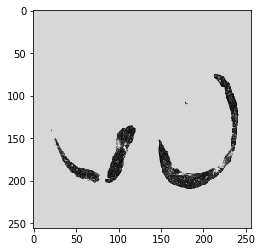

Predicted Y


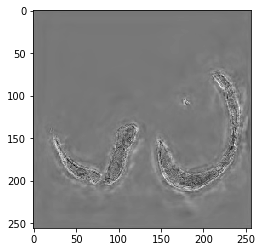

Actual Y


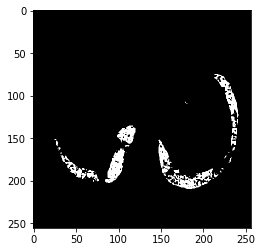

0.0000 --- loss: 0.719233
Epoch finished ! Loss: inf
Checking accuracy on test set
Validation Dice Coeff: tensor(1.00000e-02 *
       [[ 3.1917,  3.1917,  3.1917,  ...,  3.1917,  3.1917,  3.1917],
        [ 3.1917,  3.1917,  3.1917,  ...,  3.1917,  3.1917,  3.1917],
        [ 3.1917,  3.1917,  3.1917,  ...,  3.1917,  3.1917,  3.1917],
        ...,
        [ 3.1917,  3.1917,  3.1917,  ...,  3.1917,  3.1917,  3.1917],
        [ 3.1917,  3.1917,  3.1917,  ...,  3.1917,  3.1917,  3.1917],
        [ 3.1917,  3.1917,  3.1917,  ...,  3.1917,  3.1917,  3.1917]])
val_dice torch.Size([256, 256])


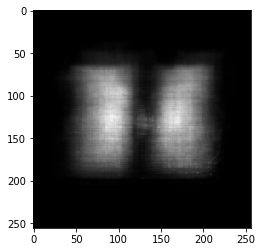

Checkpoint 1 saved !
Starting epoch 2/5.
torch.Size([4, 1, 256, 256])
X


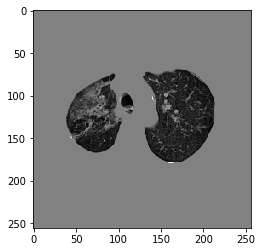

Predicted Y


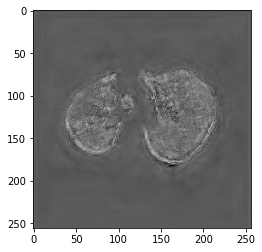

Actual Y


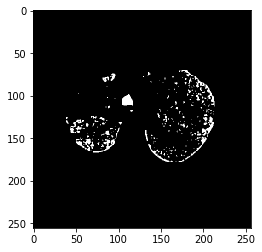

0.0000 --- loss: 0.623899
Epoch finished ! Loss: inf
Checking accuracy on test set
Validation Dice Coeff: tensor(1.00000e-02 *
       [[ 3.1915,  3.1915,  3.1915,  ...,  3.1915,  3.1915,  3.1915],
        [ 3.1915,  3.1915,  3.1915,  ...,  3.1915,  3.1915,  3.1915],
        [ 3.1915,  3.1915,  3.1915,  ...,  3.1915,  3.1915,  3.1915],
        ...,
        [ 3.1915,  3.1915,  3.1915,  ...,  3.1915,  3.1915,  3.1915],
        [ 3.1915,  3.1915,  3.1915,  ...,  3.1915,  3.1915,  3.1915],
        [ 3.1915,  3.1915,  3.1915,  ...,  3.1915,  3.1915,  3.1915]])
val_dice torch.Size([256, 256])


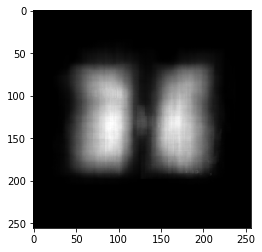

Checkpoint 2 saved !
Starting epoch 3/5.
torch.Size([4, 1, 256, 256])
X


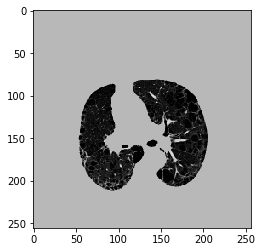

Predicted Y


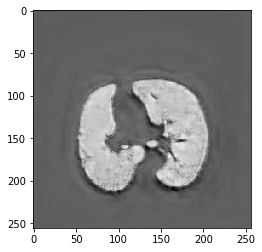

Actual Y


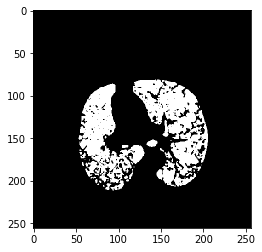

0.0000 --- loss: 0.547493
Epoch finished ! Loss: inf
Checking accuracy on test set
Validation Dice Coeff: tensor(1.00000e-02 *
       [[ 3.1917,  3.1917,  3.1917,  ...,  3.1917,  3.1917,  3.1917],
        [ 3.1917,  3.1917,  3.1917,  ...,  3.1917,  3.1917,  3.1917],
        [ 3.1917,  3.1917,  3.1917,  ...,  3.1917,  3.1917,  3.1917],
        ...,
        [ 3.1917,  3.1917,  3.1917,  ...,  3.1917,  3.1917,  3.1917],
        [ 3.1917,  3.1917,  3.1917,  ...,  3.1917,  3.1917,  3.1917],
        [ 3.1917,  3.1917,  3.1917,  ...,  3.1917,  3.1917,  3.1917]])
val_dice torch.Size([256, 256])


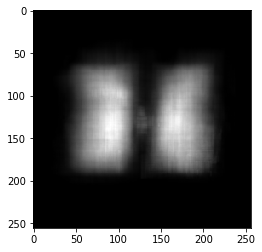

Checkpoint 3 saved !
Starting epoch 4/5.
torch.Size([4, 1, 256, 256])
X


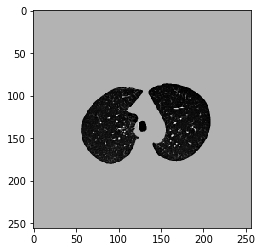

Predicted Y


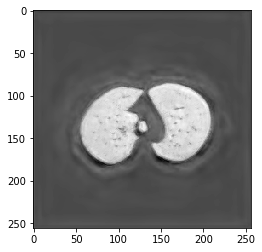

Actual Y


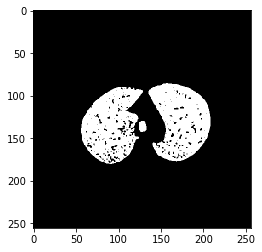

0.0000 --- loss: 0.411635
Epoch finished ! Loss: inf
Checking accuracy on test set
Saved interrupt


In [21]:
net = UNet(1, 1)

try:
    train_net(net) # , options.epochs, options.batchsize, options.lr,gpu=options.gpu)
except KeyboardInterrupt:
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    print('Saved interrupt')